In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import driver_opt_out, S_driver_opt_out, traveller_opt_out, S_traveller_opt_out
from MaaSSim.day_to_day import traveller_opt_out
from MaaSSim.day_to_day import d2d_kpi_veh
from MaaSSim.day_to_day import d2d_kpi_pax

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [12]:
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 1000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
# params.d2d.ini_exp_income = 52.8 #euro
# params.d2d.ini_exp_wt = 10 #minutes
params.d2d.ini_att = 0.5
# params.d2d.res_wage_sp = 1
# params.d2d.exp_income_sp = 1
# params.d2d.exp_utility_eps = 0
# params.d2d.veh_omega = 0.10 # degree of learning: 0<omega<1
# params.d2d.pax_omega = 0.10 # degree of learning: 0<omega<1
# params.d2d.kappa = 1
params.d2d.B_income = 1
params.d2d.fuel_cost = 0.25 #euro/km

# params.d2d.B_fare = 1/14.67
params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in oded's paper
params.PT_fare = 1 ## euro
# params.PT_speed  = 4 # m/s
params.PT_avg_speed = 6

params.nPM = 1 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = 1.21 #euro/km
params.platforms.min_fare = 2 # euro
params.platforms.comm_rate = 0

params.d2d.learning_d = 1 
params.d2d.B_Experience = 0.5
params.d2d.B_Marketing = 0.25
params.d2d.B_WOM = 0.25
params.d2d.diffusion_speed = 10/100 # this percentage should be a function of platfrom profit
params.d2d.m = 5
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 1
params.VoT = 10.63 # value of time per hour
params.assert_me = False
params.paths.requests = 'Amsterdam_requests.csv'

params.nP = 2000
params.nV = 200
params.nD = 2
params.simTime = 4
params.d2d.res_wage = params.simTime*10.63 #euro

In [18]:
# sim = MaaSSim.simulators.simulate(params=params, logger_level=logging.WARNING)
sim1 = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

# sim = MaaSSim.simulators.simulate(params=params,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

This simulation uses albatros data
29-06-22 15:11:19-WARNING-Setting up 4h simulation at 2022-06-29 13:09:46 for 200 vehicles and 2000 passengers in Amsterdam, Netherlands
29-06-22 15:11:40-WARNING-simulation time 8.7 s
29-06-22 15:12:08-WARNING-simulation time 12.4 s


In [23]:
df = sim1.res[1].veh_exp
df['nRIDES'] = df['nRIDES']*3
df

,nRIDES,nREJECTED,nDAYS_WORKED,DRIVING_TIME,DRIVING_DIST,REVENUE,COST,COMMISSION,TRIP_FARE,ACTUAL_INC,...,IS_REJECTED_BY_TRAVELLER,ARRIVES_AT_PICKUP,MEETS_TRAVELLER_AT_PICKUP,DEPARTS_FROM_PICKUP,ARRIVES_AT_DROPOFF,CONTINUES_SHIFT,STARTS_REPOSITIONING,REPOSITIONED,DECIDES_NOT_TO_DRIVE,ENDS_SHIFT
veh,,,,,,,,,,,,,,,,,,,,,
1,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


73.34689999999999

Text(0.5, 1.0, 'WOM_U')

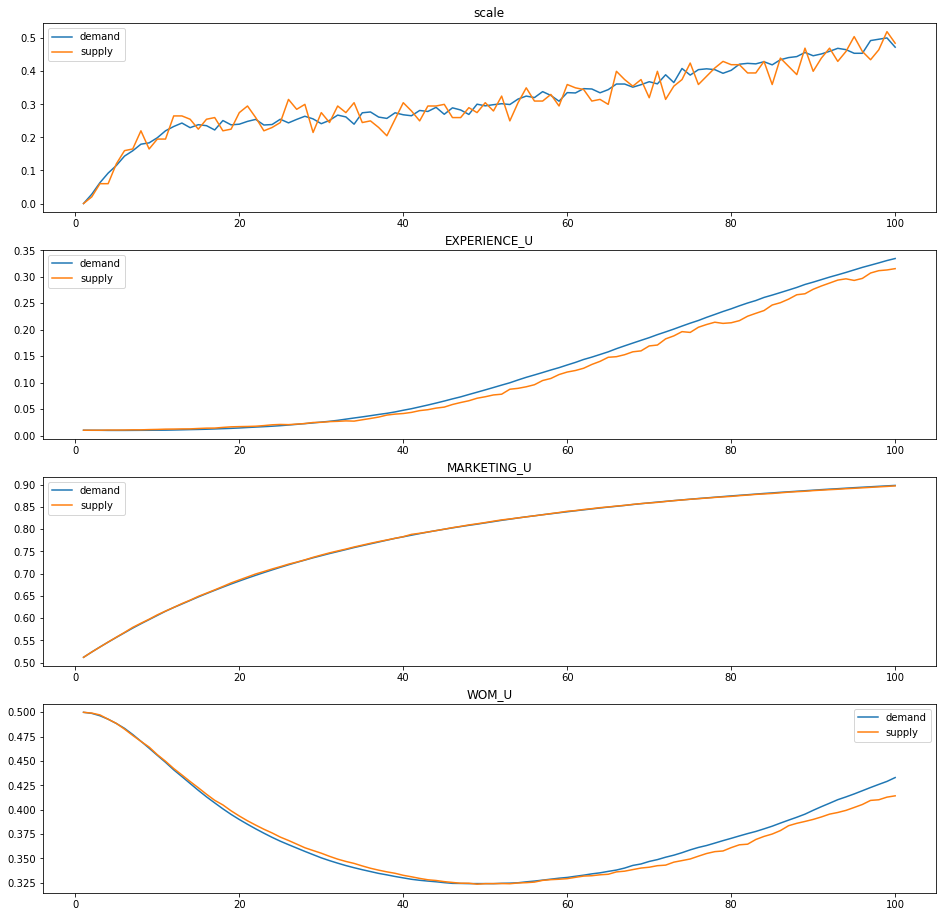

In [18]:
# with S-shaped curve nD=200 nP=2000 nV=200, with increased passenger sensitivity to changes in system
# with EXPERIENCE_U of rs starting from 0.01

lyp = []
lyd = []
sim = sim1
for d in range(0,sim.params.nD):
    lyp.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
    lyd.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
lx = [i for i in range(1,len(lyp)+1)]

fig, ax = plt.subplots(nrows=4,figsize=(16,16))
sns.lineplot(x=lx, y=lyp, label = 'demand', ax=ax[0])#, marker='o')
sns.lineplot(x=lx, y=lyd, label = 'supply', ax=ax[0])#, marker='o')
ax[0].set_title('scale')

lyp = []
lyd = []
sim = sim
for d in range(0,sim.params.nD):
    lyp.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
    lyd.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
lx = [i for i in range(1,len(lyp)+1)]
sns.lineplot(x=lx, y=lyp, label = 'demand', ax=ax[1])#, marker='o')
sns.lineplot(x=lx, y=lyd, label = 'supply', ax=ax[1])#, marker='o')
ax[1].set_title('EXPERIENCE_U')

lyp = []
lyd = []
sim = sim
for d in range(0,sim.params.nD):
    lyp.append(sim.res[d].pax_exp.MARKETING_U.mean())
    lyd.append(sim.res[d].veh_exp.MARKETING_U.mean())
lx = [i for i in range(1,len(lyp)+1)]
sns.lineplot(x=lx, y=lyp, label = 'demand', ax=ax[2])#, marker='o')
sns.lineplot(x=lx, y=lyd, label = 'supply', ax=ax[2])#, marker='o')
ax[2].set_title('MARKETING_U')

lyp = []
lyd = []
sim = sim
for d in range(0,sim.params.nD):
    lyp.append(sim.res[d].pax_exp.WOM_U.mean())
    lyd.append(sim.res[d].veh_exp.WOM_U.mean())
lx = [i for i in range(1,len(lyp)+1)]
sns.lineplot(x=lx, y=lyp, label = 'demand', ax=ax[3])#, marker='o')
sns.lineplot(x=lx, y=lyd, label = 'supply', ax=ax[3])#, marker='o')
ax[3].set_title('WOM_U')

<AxesSubplot:>

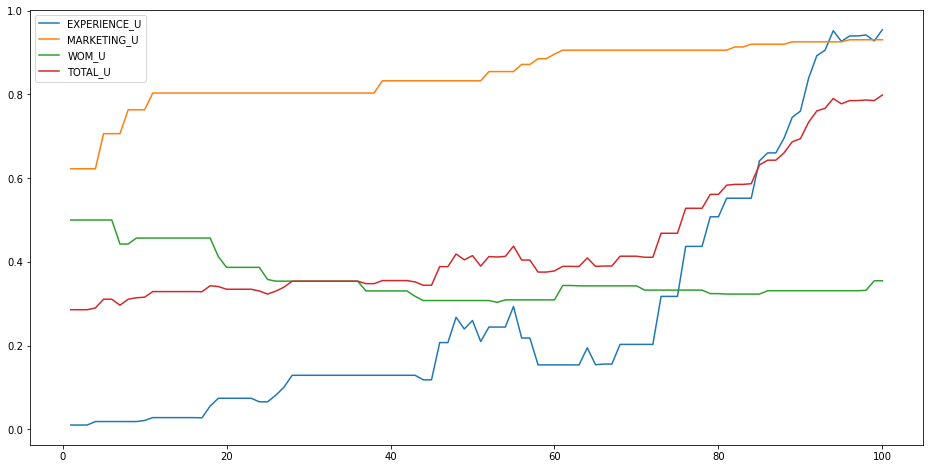

In [36]:
# individual assessment of agents
fig, ax = plt.subplots(figsize=(16,8))

veh_id = 13
x = []
ye = []
ym = []
yw = []
yu = []

for d in range(0,sim.params.nD):
    ye.append(sim.res[d].veh_exp.loc[veh_id].EXPERIENCE_U)
    ym.append(sim.res[d].veh_exp.loc[veh_id].MARKETING_U)
    yw.append(sim.res[d].veh_exp.loc[veh_id].WOM_U)
    yu.append((0.5*ye[-1])+(0.25*ym[-1])+(0.25*yw[-1]))
    
x = [i for i in range(1,len(ye)+1)]
sns.lineplot(x=x, y=ye, label = 'EXPERIENCE_U')#, ax=ax[0])#, marker='o')
sns.lineplot(x=x, y=ym, label = 'MARKETING_U')#, ax=ax[1])#, marker='o')
sns.lineplot(x=x, y=yw, label = 'WOM_U')#, ax=ax[2])#, marker='o')
sns.lineplot(x=x, y=yu, label = 'TOTAL_U')#, ax=ax[3])#, marker='o')

In [ ]:
Important remarks:
    
1- Scince the urilities are changing in (0,1), each driver should converge to a specific attitude 0 or 1.
After a while. This does not happen in Arjan's or Djavadians model.

2- The stability of on driver depends on endogenous factor of EXPERIENCE_U and WOM and Marketing. So we
will see the complete convergance will happen when the marketing reaches to max effect 1. and other drivers
converge (wom).

3- large scales on both demand and supply sides brings an extra utility in terms of lower pick up times.

4- increasing we increase the coefficient of the diff in experience, agents are learning faster.

5- in the basic model drivers are more sensitive than passengers to the changes in system. Because 
passengers are considering other factors like trip fare beside waiting time. That is why driver scale obeys
passenger scale. This prevents the network effect to happen. however, to increase passenger sensitivity we
increase the wait time coefficient in the utility formula.

In [ ]:
1. word of mouth? 0 or 0.5 considering rh_U starting from 0!
2. Experinced utility of rh is never worse than pt!